In [1]:
from langchain_core.messages import BaseMessage,HumanMessage,SystemMessage
from langgraph.graph import StateGraph
from langgraph.prebuilt import ToolNode,tools_condition
from langgraph.graph.message import add_messages
from typing import Annotated, Sequence
from langchain.tools import tool

from langchain_google_genai import ChatGoogleGenerativeAI

from typing import Annotated,Union
from pydantic import BaseModel,Field

In [2]:
from langchain.utilities import SQLDatabase

# Point to your local movies.db
db = SQLDatabase.from_uri("sqlite:///imdb_data.db")


In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
class AgentState(BaseModel):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [5]:
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    google_api_key=os.getenv("GOOGLE_API_KEY"))

### Tools

In [6]:
from langchain.agents.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)
db_tools = toolkit.get_tools()

In [7]:
llm_with_tools = llm.bind_tools(db_tools)

In [14]:
from langchain import hub
prompt_template = hub.pull("langchain-ai/sql-agent-system-prompt")
system_message = prompt_template.format(dialect="SQLite", top_k=5)

## can be use for builtin prompt for improves accuracy of SQL query generation.

d:\Programming\Python in Sublime\Global_Environment_2\Global2\Lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [15]:
def agent_node(state: AgentState) -> AgentState:
    # system_prompt = SystemMessage(content=
    #     "You are my AI assistant, please answer my query to the best of your ability."
    # )
    system_prompt = SystemMessage(content=system_message)
    response = llm_with_tools.invoke([system_prompt]+state.messages)
    return {"messages": [response]}

In [16]:
graph = StateGraph(AgentState)

graph.add_node(node="db_agent",action=agent_node)
graph.add_node(node="tools",action=ToolNode(tools=db_tools))

graph.set_entry_point(key="db_agent")

graph.add_conditional_edges(source="db_agent",path=tools_condition)

graph.add_edge(start_key="tools",end_key="db_agent")
graph.set_finish_point(key="db_agent")


app = graph.compile()

In [ ]:
inputs = {
    "messages": 
    [HumanMessage(
        content="""show me top 5 horror films base on rating in table name 'movies'?
        and Tell me a joke about late night sleeping""")]
}

# for step in app.stream(inputs, stream_mode="values"):
#     step["messages"][-1].pretty_print()


================================ Human Message =================================

show me top 5 horror films base on rating in table name 'movies'?
        and Tell me a joke about late night sleeping
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (05477b2e-068f-43d1-afe4-13da1da70c3b)
 Call ID: 05477b2e-068f-43d1-afe4-13da1da70c3b
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

movies
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (e7dbc871-2eaf-4fd2-97b5-bf9267fac0d0)
 Call ID: e7dbc871-2eaf-4fd2-97b5-bf9267fac0d0
  Args:
    table_names: movies
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE movies (
	"Title" TEXT, 
	"IMDb Rating" REAL, 
	"Year" INTEGER, 
	"Certificates" TEXT, 
	"Genre" TEXT, 
	"Director" TEXT, 
	"Star Cast

In [22]:
## print the only last message of the llm
result = app.invoke(inputs)
result["messages"][-1].content.split("\n")

['Here are the top 5 horror films based on their IMDb rating:',
 '',
 '*   Alien (IMDb Rating: 8.5)',
 '*   Alien (IMDb Rating: 8.5)',
 '*   Split (IMDb Rating: 7.3)',
 '*   Talk to Me (IMDb Rating: 7.1)',
 '*   Alien: Romulus (IMDb Rating: 7.1)',
 '',
 "And here's a joke for you:",
 '',
 'Why did the bed break up with the pillow?',
 'Because it felt like it was always getting a late-night call!']

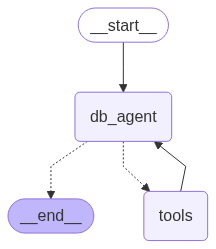

In [13]:
from IPython.display import display,Image
display(Image(app.get_graph().draw_mermaid_png()))